In [1]:
import scipy
import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
from sympy import MutableDenseMatrix, conjugate, Function, Symbol, diff, simplify, lambdify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

plt.rcParams["font.family"] = "Arial"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 3
nexcite = 1
ntotal = 4

In [3]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix31toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix31toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix31toy3.csv',delimiter=',')

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

ϕ = Symbol(u'ϕ', real = True)
θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)
k = Symbol(u'k', real = True)
v = Symbol(u'v', real = True)
t = Symbol(u't', real = True)
x = v*t

In [5]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-g*B,E0,E0+g*B,Ee])

In [6]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (-1)**(0)*2*cos(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)
DH = simplify(diff(ham.transformed,t)/v)

In [8]:
ham.transformed

Matrix([
[                          -B*g - 1.0*Δ,                                     0,                                     0, -0.235702260395516*Ω*sin(θ)*cos(k*t*v)],
[                                     0,                                -1.0*Δ,                                     0,  0.333333333333333*Ω*cos(θ)*cos(k*t*v)],
[                                     0,                                     0,                           B*g - 1.0*Δ,  0.235702260395516*Ω*sin(θ)*cos(k*t*v)],
[-0.235702260395516*Ω*sin(θ)*cos(k*t*v), 0.333333333333333*Ω*cos(θ)*cos(k*t*v), 0.235702260395516*Ω*sin(θ)*cos(k*t*v),                                      0]])

In [9]:
ham.hamiltonian

Matrix([
[                                             -B*g + E0,                                                     0,                                                     0, -0.235702260395516*Ω*exp(1.0*I*t*ω)*sin(θ)*cos(k*t*v)],
[                                                     0,                                                    E0,                                                     0,  0.333333333333333*Ω*exp(1.0*I*t*ω)*cos(θ)*cos(k*t*v)],
[                                                     0,                                                     0,                                              B*g + E0,  0.235702260395516*Ω*exp(1.0*I*t*ω)*sin(θ)*cos(k*t*v)],
[-0.235702260395516*Ω*exp(-1.0*I*t*ω)*sin(θ)*cos(k*t*v), 0.333333333333333*Ω*exp(-1.0*I*t*ω)*cos(θ)*cos(k*t*v), 0.235702260395516*Ω*exp(-1.0*I*t*ω)*sin(θ)*cos(k*t*v),                                                    Ee]])

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [12]:
BR[nground:,:]

array([[0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [13]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


In [14]:
dis.dissipator

Matrix([
[0.333333333333333*Γ*ρ₃₃(t),                          0,                          0, -0.5*Γ*ρ₀₃(t)],
[                         0, 0.333333333333333*Γ*ρ₃₃(t),                          0, -0.5*Γ*ρ₁₃(t)],
[                         0,                          0, 0.333333333333333*Γ*ρ₃₃(t), -0.5*Γ*ρ₂₃(t)],
[  -0.5*Γ*conjugate(ρ₀₃(t)),   -0.5*Γ*conjugate(ρ₁₃(t)),   -0.5*Γ*conjugate(ρ₂₃(t)), -1.0*Γ*ρ₃₃(t)]])

In [15]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 218 ms


In [16]:
from julia import Main

nprocs = 5 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([1, 2, 3, 4, 5], dtype=int64)

In [17]:
hamiltonian_symbols = ham.transformed.free_symbols
hamiltonian_symbols = [d for d in hamiltonian_symbols if str(d)[0] not in ['t']]
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = [d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']]
                      
lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);

    

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        hval = hval.replace('I','icomplex')
        print(hval)
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

-B*g - 1.0*Δ
0
0
-0.235702260395516*Ω*sin(θ)*cos(k*t*v)
0
-1.0*Δ
0
0.333333333333333*Ω*cos(θ)*cos(k*t*v)
0
0
B*g - 1.0*Δ
0.235702260395516*Ω*sin(θ)*cos(k*t*v)
-0.235702260395516*Ω*sin(θ)*cos(k*t*v)
0.333333333333333*Ω*cos(θ)*cos(k*t*v)
0.235702260395516*Ω*sin(θ)*cos(k*t*v)
0


In [18]:
# Creating the system of equations
Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    @named bloch = ODESystem(eqns)
    tmp = 0
end
""");
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [19]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(nground):
    y0[_,_] = 1/nground
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [20]:
print(hamiltonian_symbols,dissipator_symbols)

[k, v, θ, Δ, Ω, g, B] [Γ]


In [21]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    θ => pi/4,
    B => 0,
    k => 1,
    Δ => 2.5,
    Ω => 1,
    g => 0,
    Γ => 1,
    v => 0.1,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [22]:
%%time
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0., 5000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

Wall time: 35.2 s


Wall time: 3.1 s


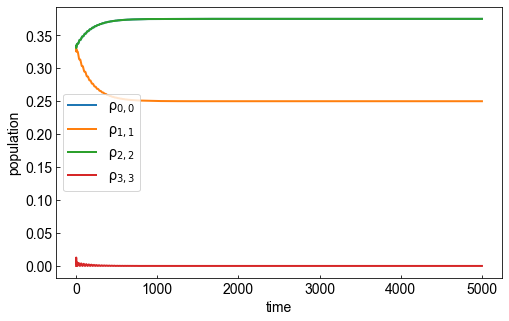

In [23]:
%%time
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5())");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t")
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [24]:
DH

Matrix([
[                                      0,                                        0,                                        0,  0.235702260395516*k*Ω*sin(θ)*sin(k*t*v)],
[                                      0,                                        0,                                        0, -0.333333333333333*k*Ω*sin(k*t*v)*cos(θ)],
[                                      0,                                        0,                                        0, -0.235702260395516*k*Ω*sin(θ)*sin(k*t*v)],
[0.235702260395516*k*Ω*sin(θ)*sin(k*t*v), -0.333333333333333*k*Ω*sin(k*t*v)*cos(θ), -0.235702260395516*k*Ω*sin(θ)*sin(k*t*v),                                        0]])

# 1D scan code

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.12s/it]


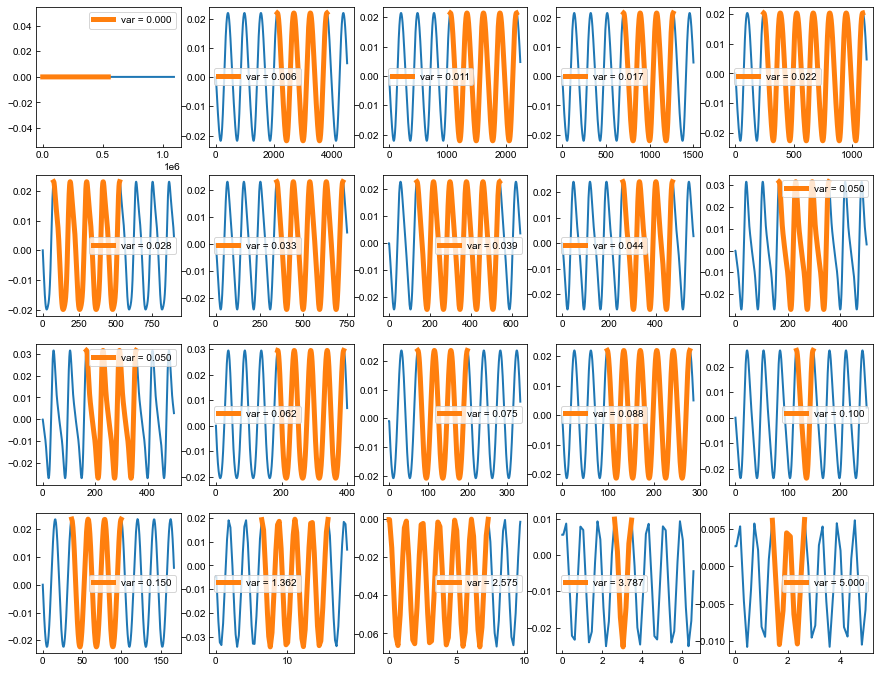

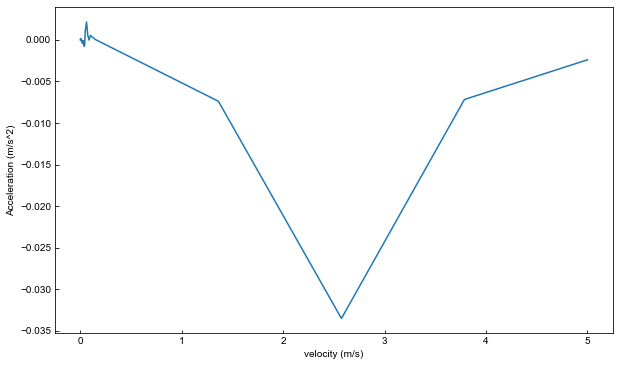

Wall time: 1min 4s


In [28]:
%%time
# varlist = np.linspace(0,5,10)
varlist = np.concatenate([np.linspace(0.,0.05,10),np.linspace(0.05,0.10,5),np.linspace(0.15,5,5)])

Main.params = varlist
Main.eval("@everywhere params = $params")
Main.eval("@everywhere Ω_val = sqrt(2)")
Main.eval("@everywhere theta_val = 45/180*pi")
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => theta_val,
        B => 0.1,
        k => 1.,
        Δ => 2.5,
        Ω => Ω_val,
        g => 1.,
        Γ => 1.,
        v => params[i],
        icomplex => im
        ], parameters(bloch))
    tspan = (-5000., 500*0.05/params[i])
   remake(prob, p = pnew, tspan = tspan)
end
""")
#   or to use:  tspan = (-5000., 500*0.05/params[i])

Main.eval("""
@everywhere function output_func(sol,i)
    ind = findmin(abs.(sol.t.-0.))[2]
    return [sol.t[ind:end],sol.u[ind:end]], false
end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true,reltol =1e-6)
sim.elapsedTime
""")
all_results = Main.eval("""sim.u""")

prefactor = 1
DH_new = prefactor*DH.subs([(k, 1.),(Ω, Main.Ω_val),(θ, Main.theta_val)])
δH = lambdify((v,t), DH_new, modules='numpy')
force_allvar = []
pltdim = int(np.sqrt(len(varlist))+1)
fig = plt.figure(figsize = (15,15))

for ind in tqdm(range(len(varlist))):
    t_array = all_results[ind][0]
    ρt = np.array(all_results[ind][1]).reshape(-1,ntotal,ntotal)
    ex_pop = np.array([np.sum([np.real(ρt[_,__,__]) for __ in range(nground,ntotal)]) for _ in range(len(t_array))])
    force_list = []
    for t_ind in range(len(t_array)):
        dH = δH(varlist[ind],t_array[t_ind])
        f_temp = -np.matmul(ρt[t_ind],dH)
        force = np.trace(np.real(f_temp))
        force_list.append(force)

    sample_size = 3000
    t_max = t_array[-1]
    t_interp = np.linspace(0,t_max,sample_size)
    force_interp = np.interp(t_interp,t_array,force_list)
    t_midind = int(sample_size/2)

    max_sig_ind_in_1 = np.argmax(force_interp[0:t_midind])
    max_sig_ind_in_2 = np.argmax(force_interp[t_midind:])+t_midind
    fig.add_subplot(pltdim,pltdim,ind+1)
    plt.plot(t_interp,force_interp,lw=2)
    plt.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],force_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5,label = f'var = {varlist[ind]:.3f}')
    force_int = np.mean(force_interp[max_sig_ind_in_1:max_sig_ind_in_2])
    force_allvar.append(force_int)
    plt.legend()
plt.show()

plt.figure(figsize = (10,6))
plt.plot(varlist, force_allvar)
plt.xlabel('velocity (m/s)')
plt.ylabel('Acceleration (m/s^2)')
plt.show()


# 2D scan code

In [35]:
def sweep_vel_get_force(varlist, Δ_input=2.5, B_input=1, θ_input=30/180*np.pi, Ω_val=np.sqrt(2)):
    Main.params = varlist
    Main.eval("@everywhere params = $params")
    Main.eval(f"""
    @everywhere function prob_func(prob,i,repeat)
        pnew = ModelingToolkit.varmap_to_vars([
            θ => {θ_input},
            B => {B_input},
            k => 1.,
            Δ => {Δ_input},
            Ω => {Ω_val},
            g => 1.,
            Γ => 1.,
            v => params[i],
            icomplex => im
            ], parameters(bloch))
        tspan = (-3000., 100*0.3/params[i])
       remake(prob, p = pnew, tspan = tspan)
    end
    """)
    #     tspan = (-5000., 5000*0.005/params[i])

    Main.eval("""
    @everywhere function output_func(sol,i)
        ind = findmin(abs.(sol.t.-0.))[2]
        return [sol.t[ind:end],sol.u[ind:end]], false
    end
    """)
    Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                       save_everystep = true; trajectories = size(params)[1], adaptive=true,reltol =1e-6)
    sim.elapsedTime
    """)
    all_results = Main.eval("""sim.u""")

    prefactor = 1
    DH_new = prefactor*DH.subs([(k, 1.),(Ω, Ω_val),(θ, θ_input)])
    δH = lambdify((v,t), DH_new, modules='numpy')
    force_allvar = []
    pop_allvar = []
    pltdim = int(np.sqrt(len(varlist))+1)
    fig = plt.figure(figsize = (15,15))
    fig2 = plt.figure(figsize = (15,15))

    for ind in tqdm(range(len(varlist))):
        t_array = all_results[ind][0]
        ρt = np.array(all_results[ind][1]).reshape(-1,ntotal,ntotal)
        ex_pop = np.array([np.sum([np.real(ρt[_,__,__]) for __ in range(nground,ntotal)]) for _ in range(len(t_array))])
        force_list = []
        for t_ind in range(len(t_array)):
            dH = δH(varlist[ind],t_array[t_ind])
            f_temp = -np.matmul(ρt[t_ind],dH)
            force = np.trace(np.real(f_temp))
            force_list.append(force)

        sample_size = 3000
        t_max = t_array[-1]
        t_interp = np.linspace(0,t_max,sample_size)
        force_interp = np.interp(t_interp,t_array,force_list)
        t_midind = int(sample_size/2)

        max_sig_ind_in_1 = np.argmax(force_interp[0:t_midind])
        max_sig_ind_in_2 = np.argmax(force_interp[t_midind:])+t_midind
        ax = fig.add_subplot(pltdim,pltdim,ind+1)
        ax.plot(t_interp,force_interp,lw=2)
        ax.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],force_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5,label = f'var = {varlist[ind]:.3f}')
        force_int = np.mean(force_interp[max_sig_ind_in_1:max_sig_ind_in_2])
        force_allvar.append(force_int)
        ax.legend()
        
        ax2 = fig2.add_subplot(pltdim,pltdim,ind+1)
        pop_interp = np.interp(t_interp,t_array,ex_pop)
        ax2.plot(t_interp,pop_interp,lw=2)
        ax2.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],pop_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5,label = f'var = {varlist[ind]:.3f}')
        ax2.legend()
        pop_int = np.mean(pop_interp[max_sig_ind_in_1:max_sig_ind_in_2])
        pop_allvar.append(pop_int)
    plt.show()

    plt.figure(figsize = (10,6))
    plt.plot(varlist, force_allvar,label='force')
    plt.plot(varlist, -np.array(pop_allvar),label='exc pop')
    plt.xlabel('velocity (Γ/k)')
    plt.ylabel('force (ħkΓ)')
    plt.legend()
#     plt.show()
    return force_allvar

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.82it/s]


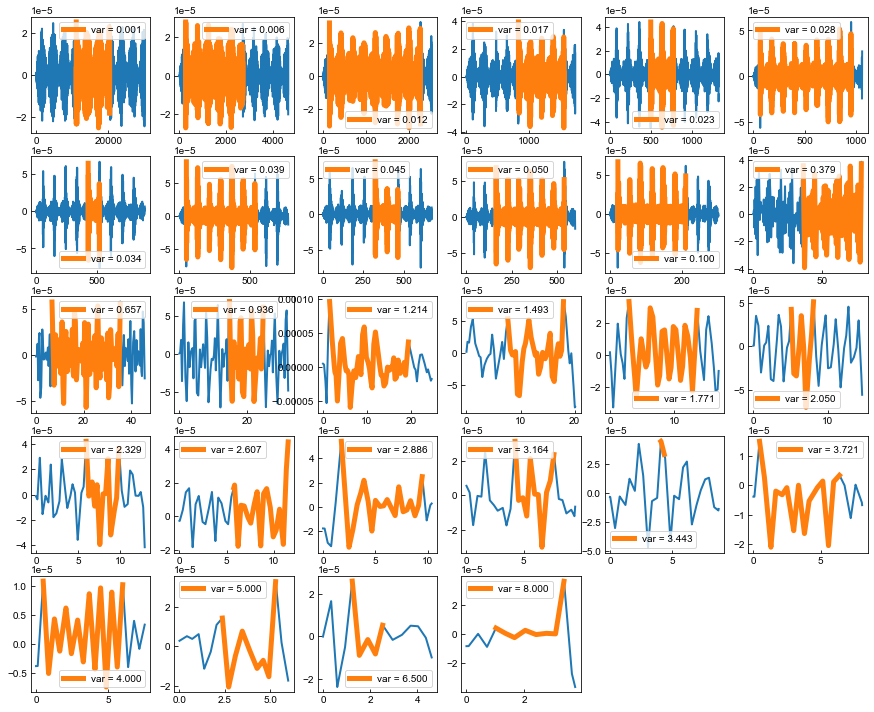

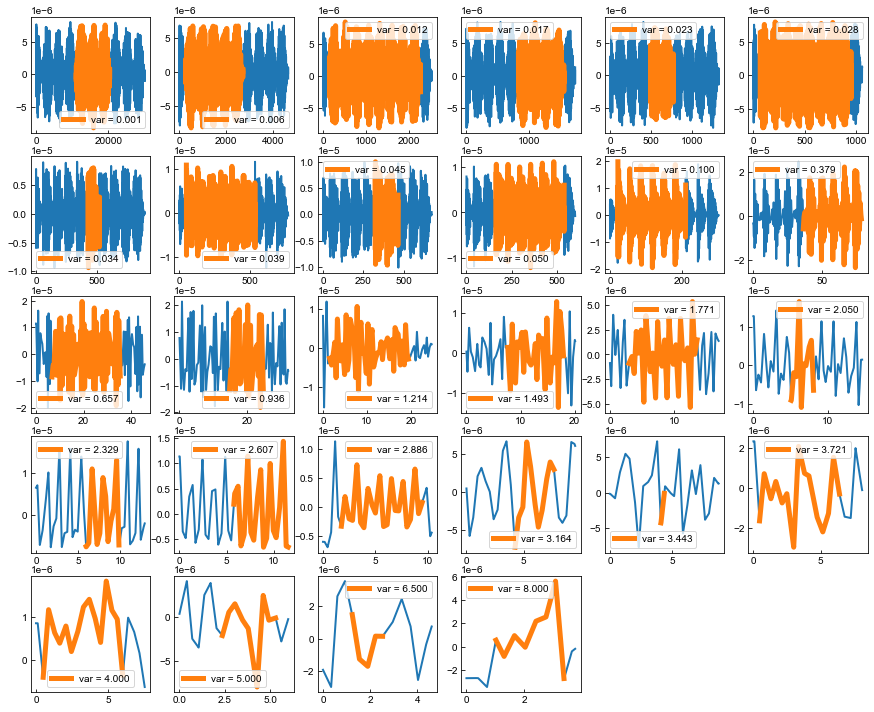

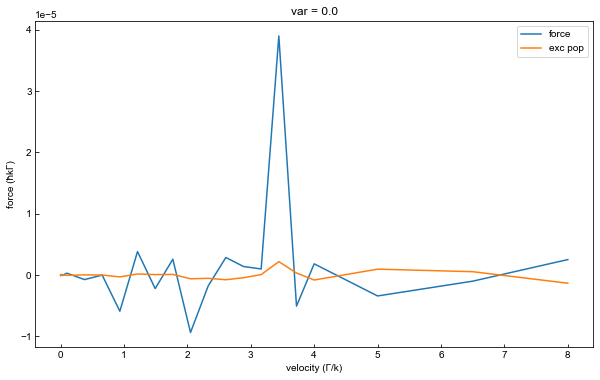

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.46it/s]


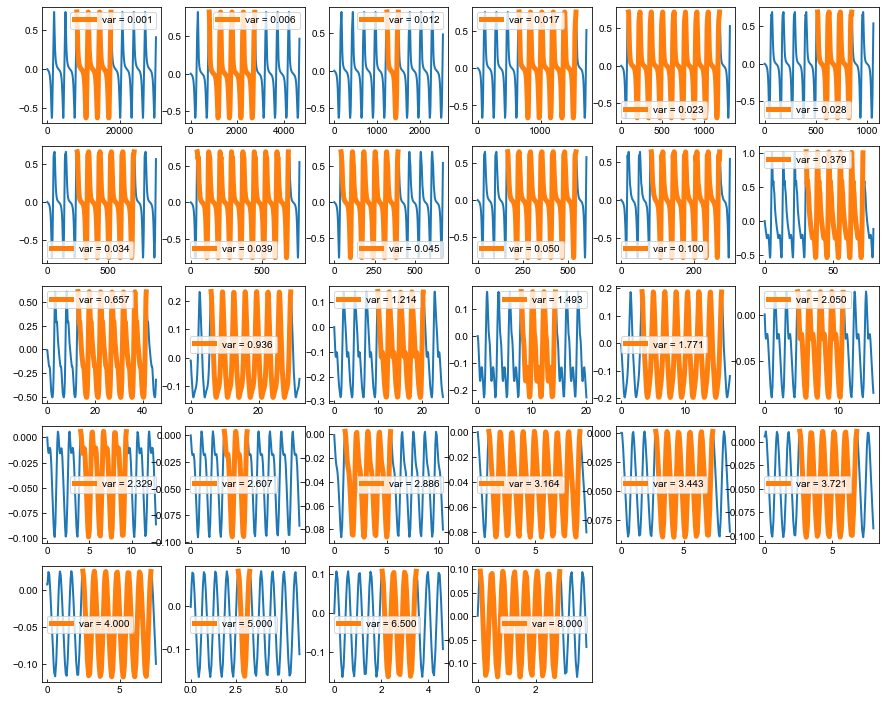

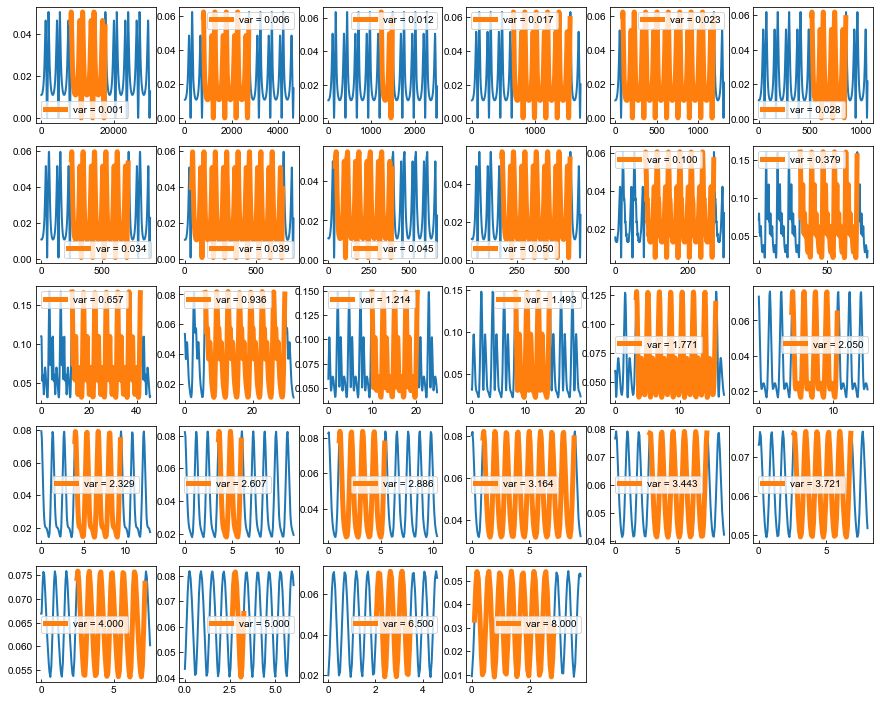

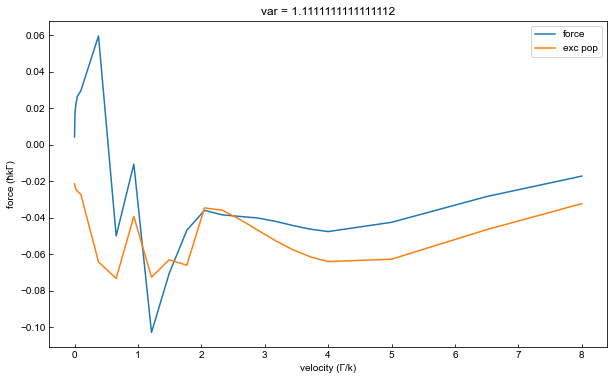

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.72it/s]


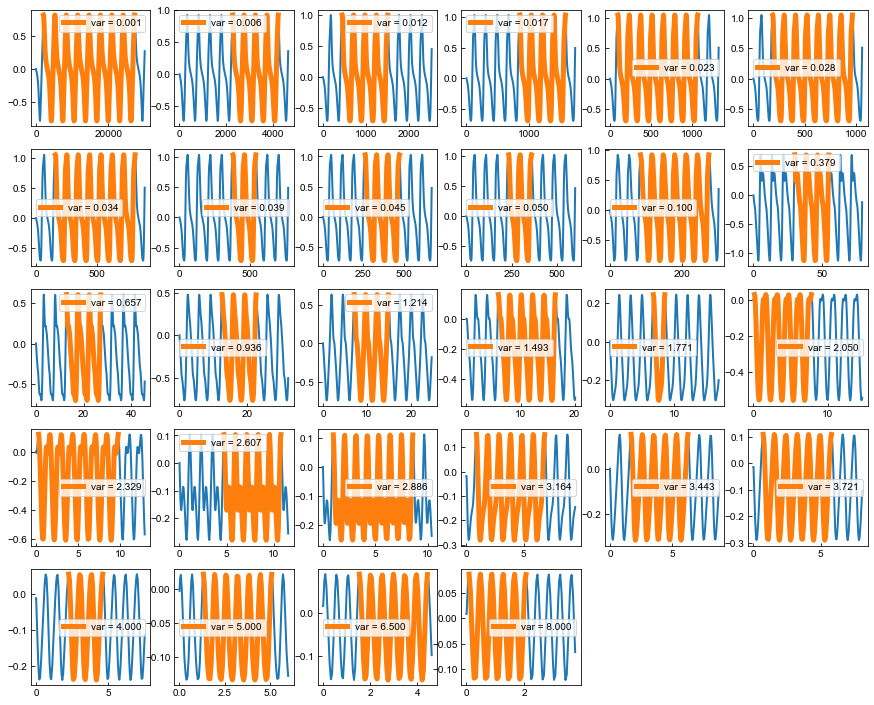

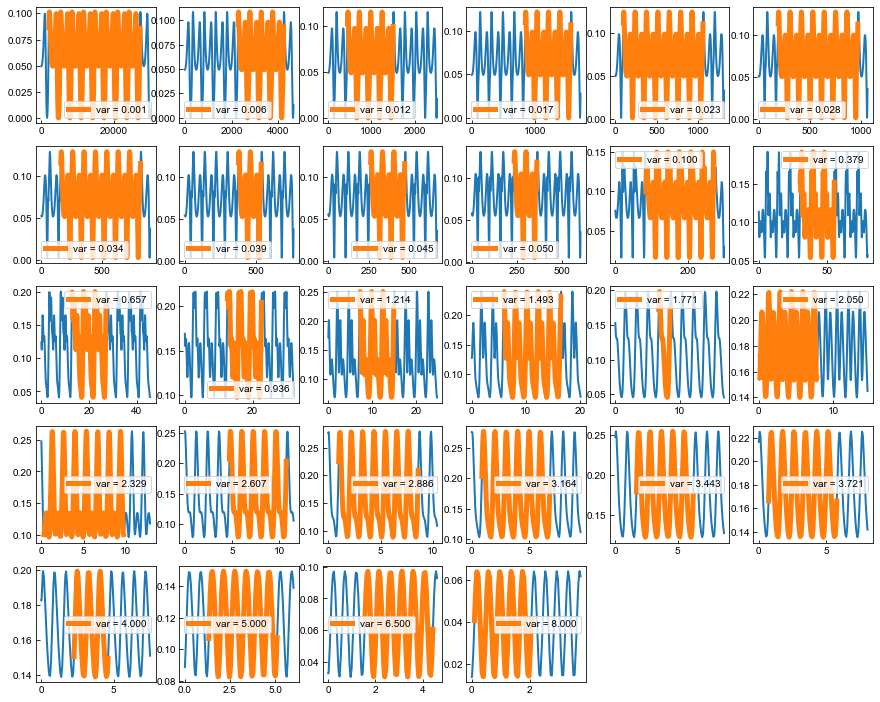

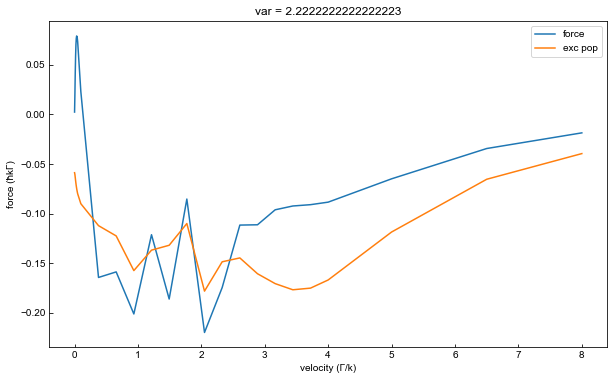

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.78it/s]


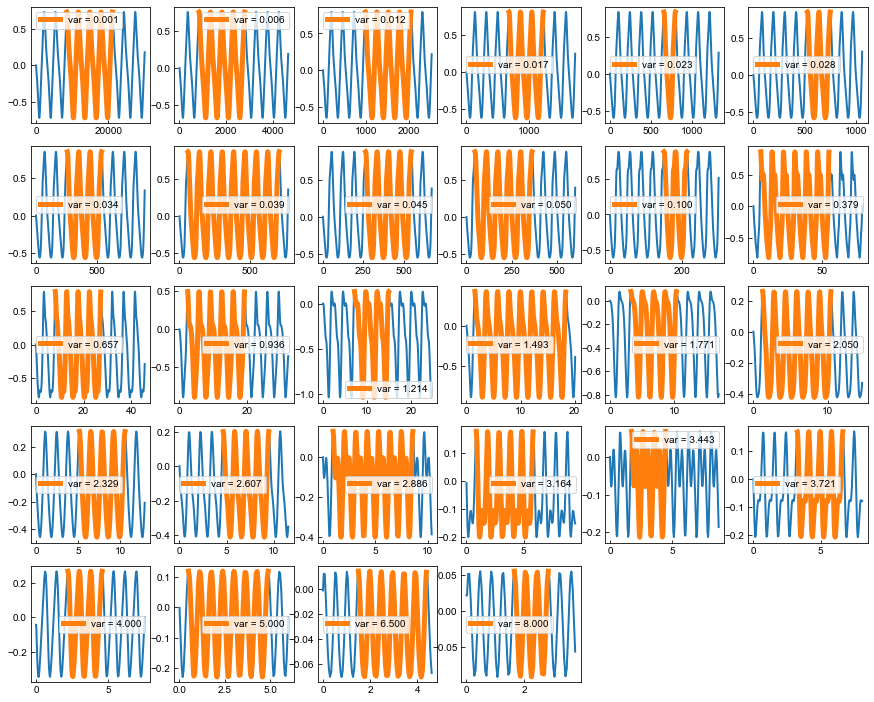

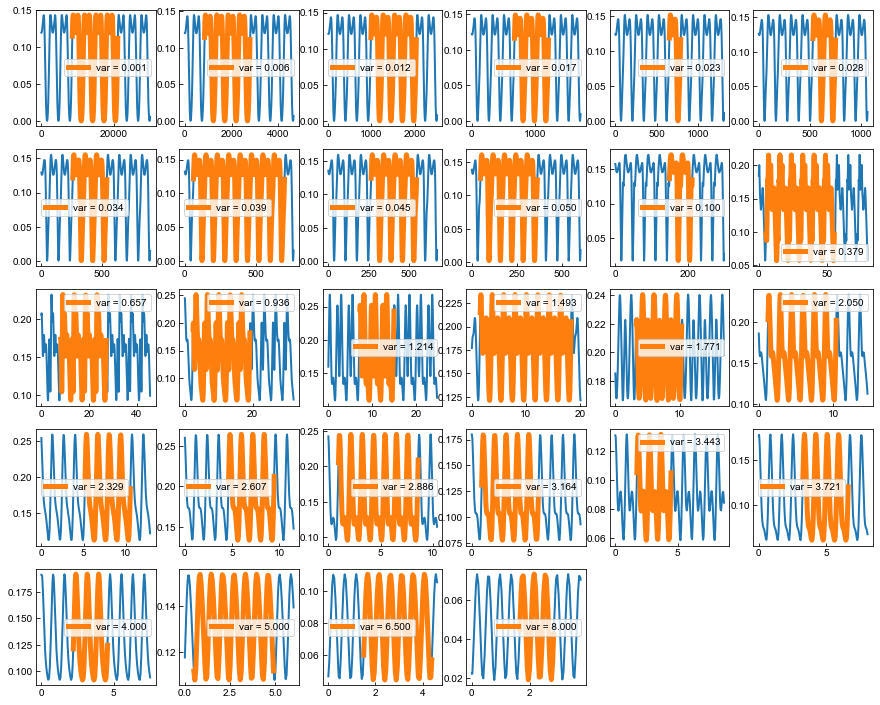

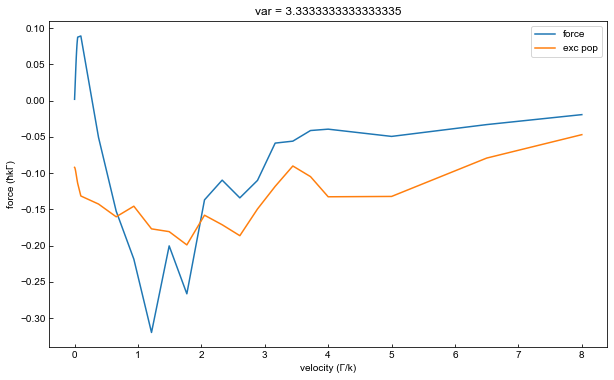

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:09<00:00,  3.08it/s]


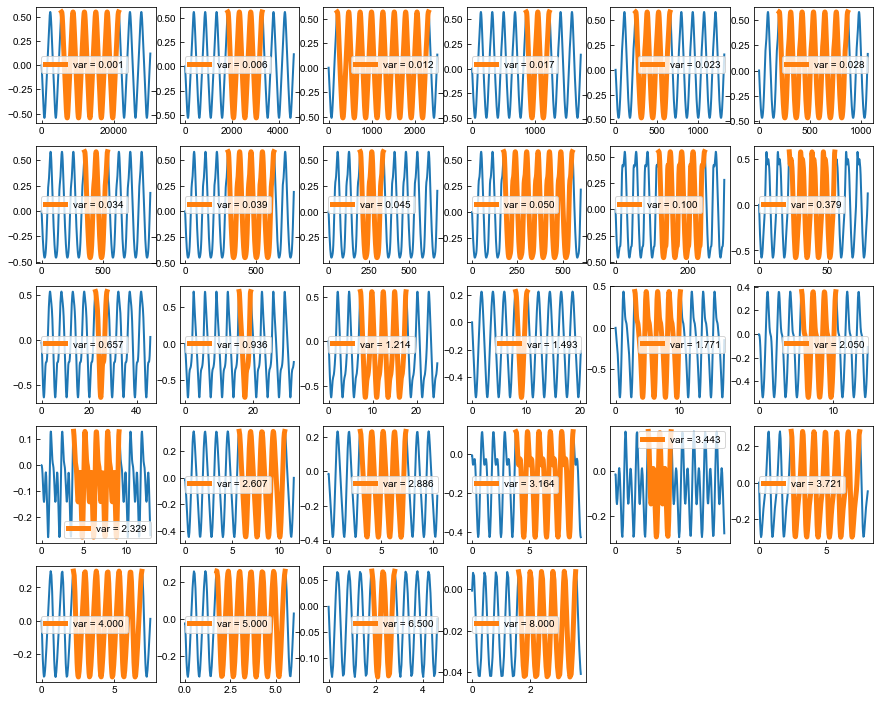

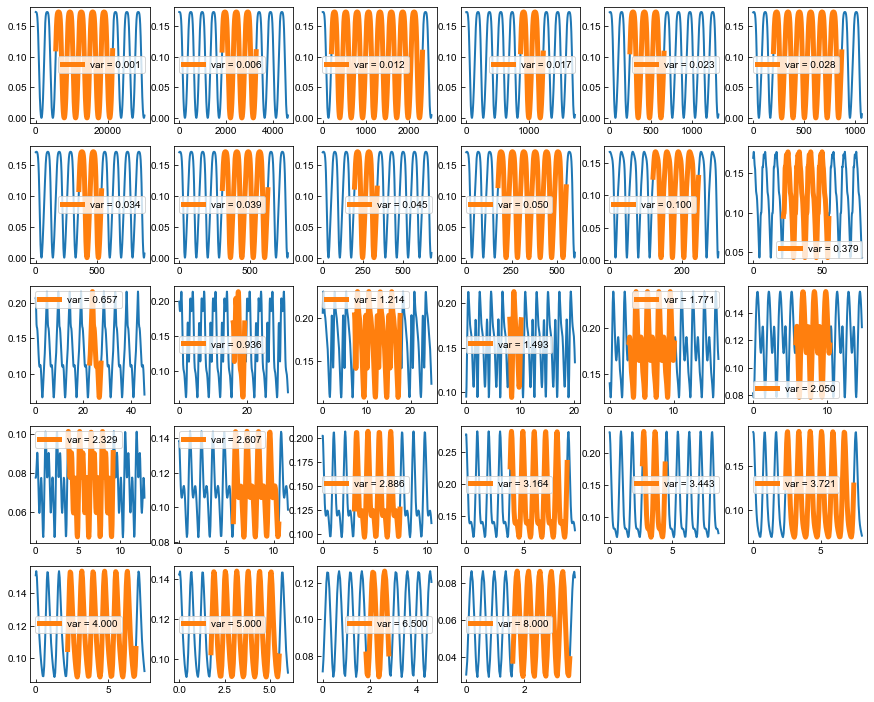

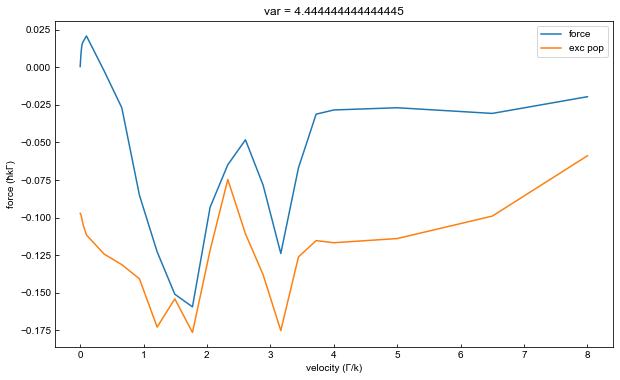

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:13<00:00,  2.15it/s]


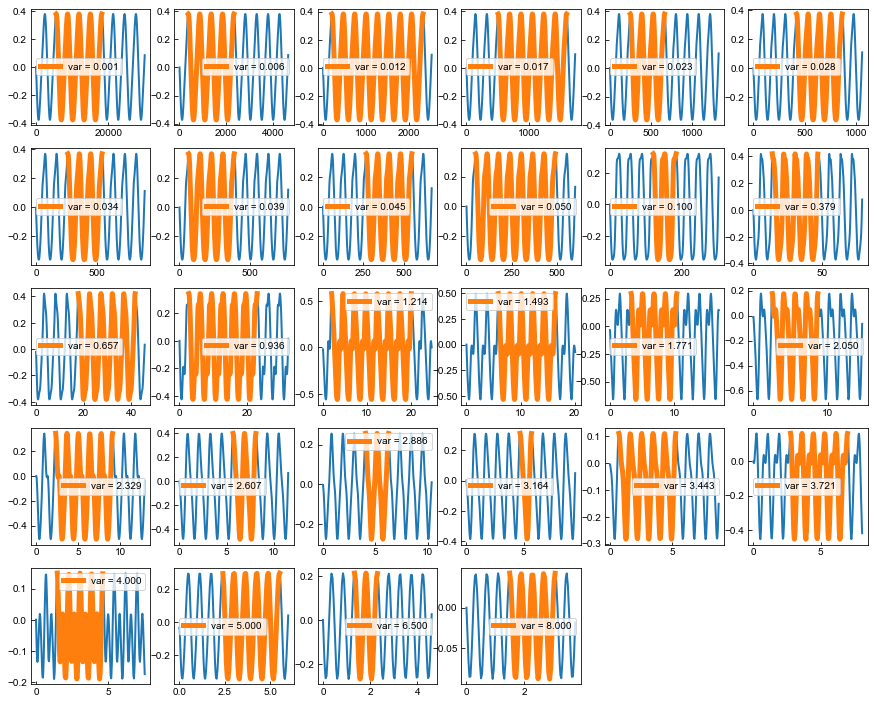

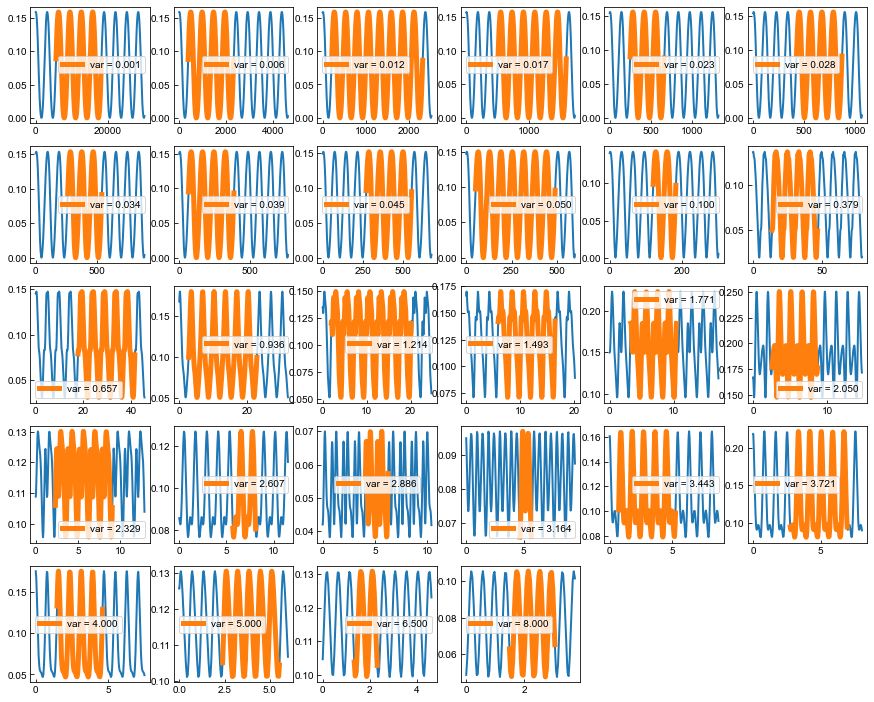

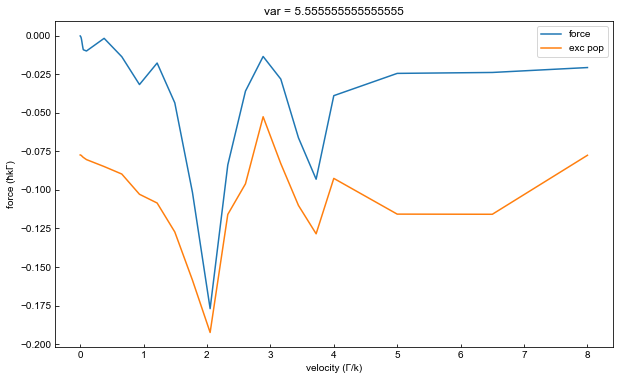

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:20<00:00,  1.33it/s]


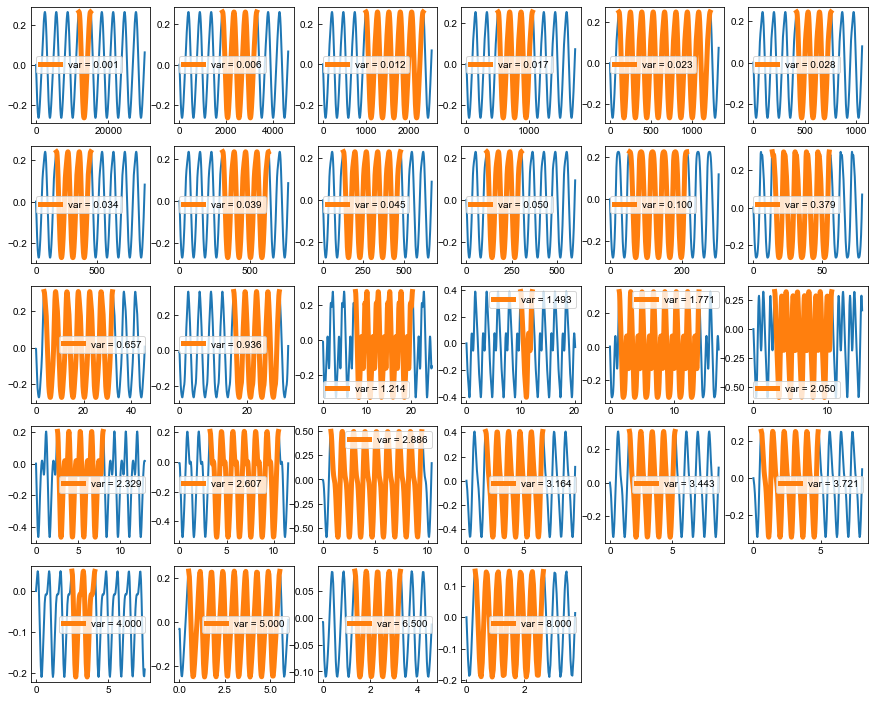

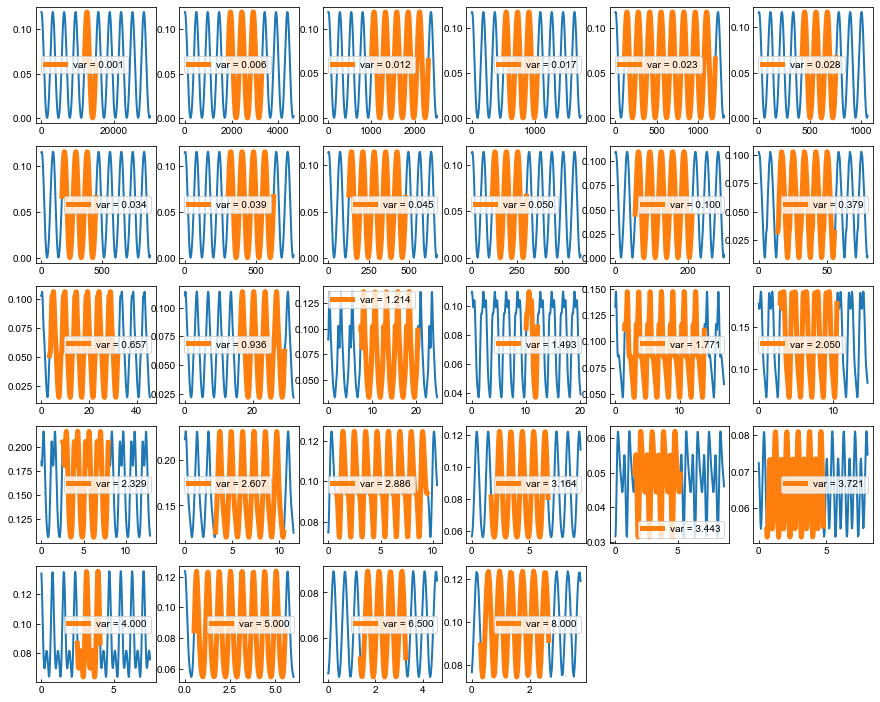

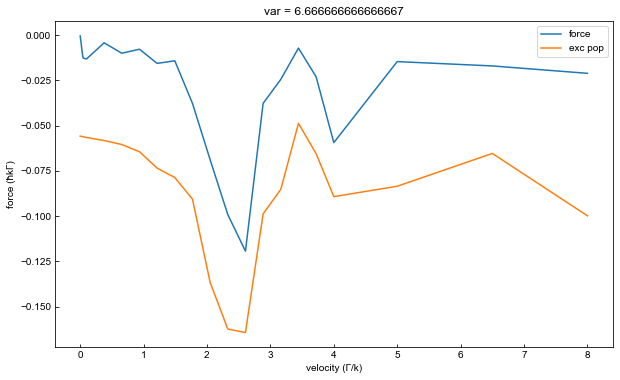

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.01it/s]


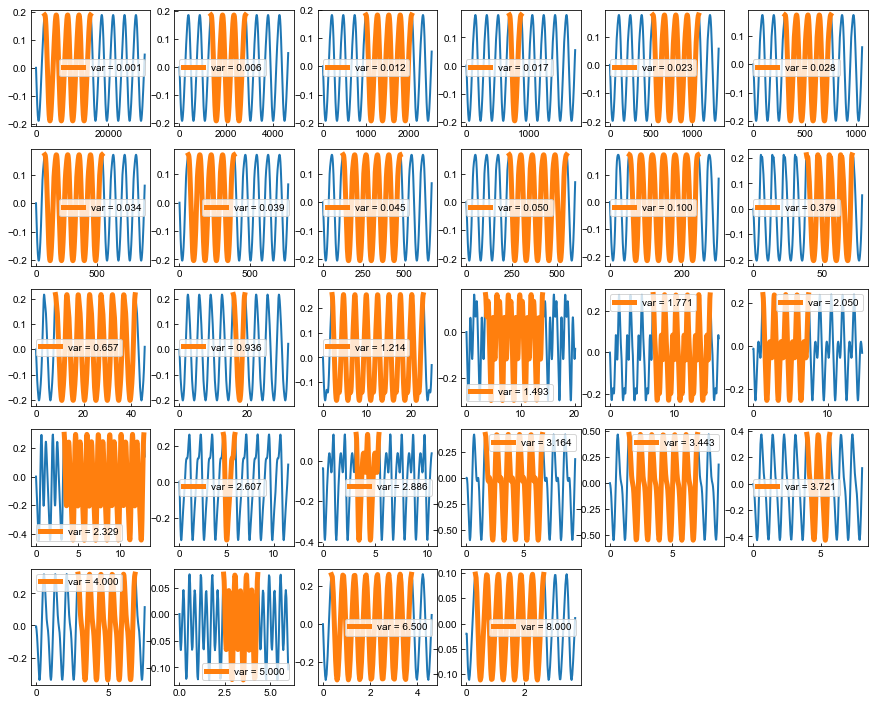

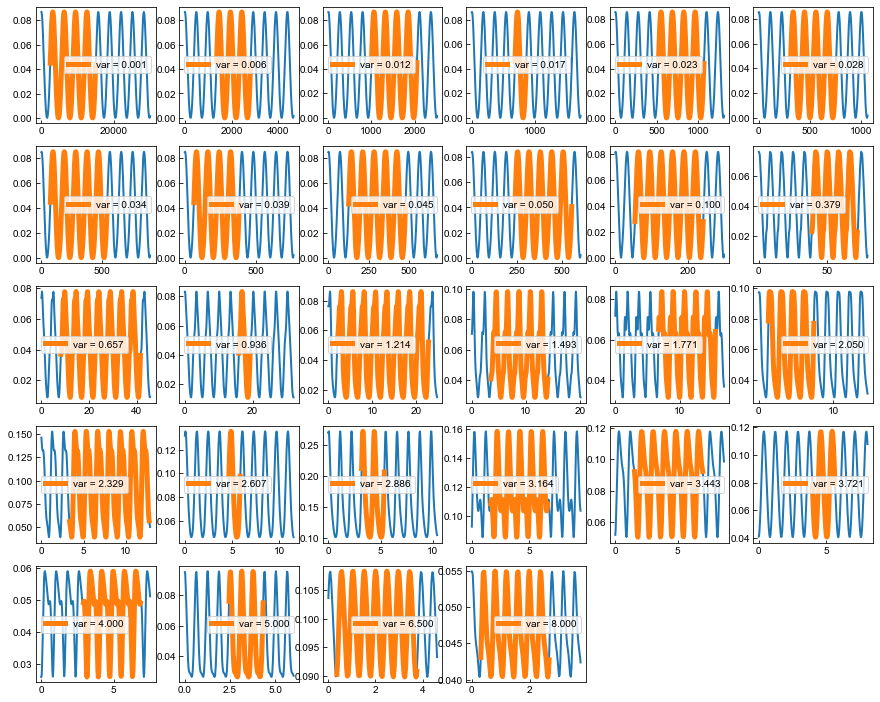

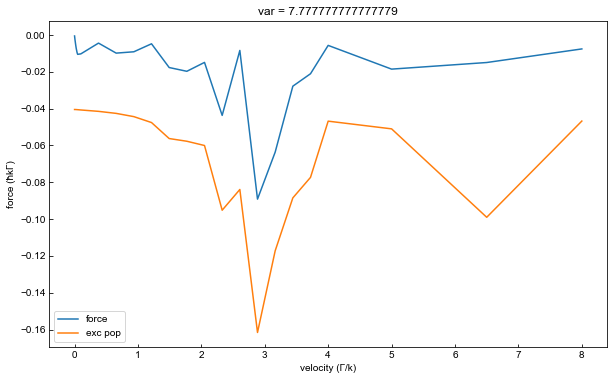

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:21<00:00,  1.31it/s]


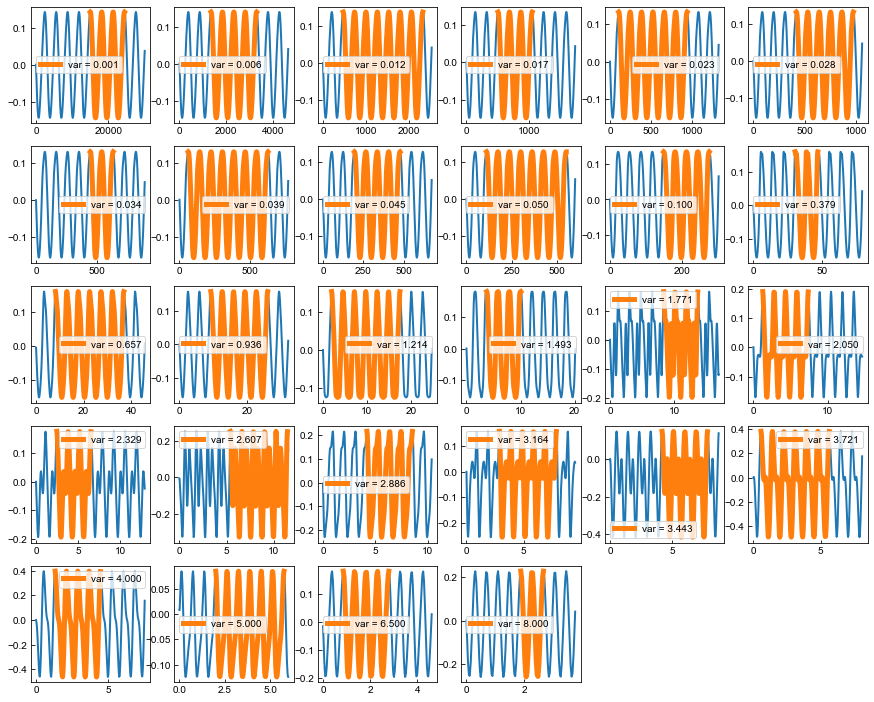

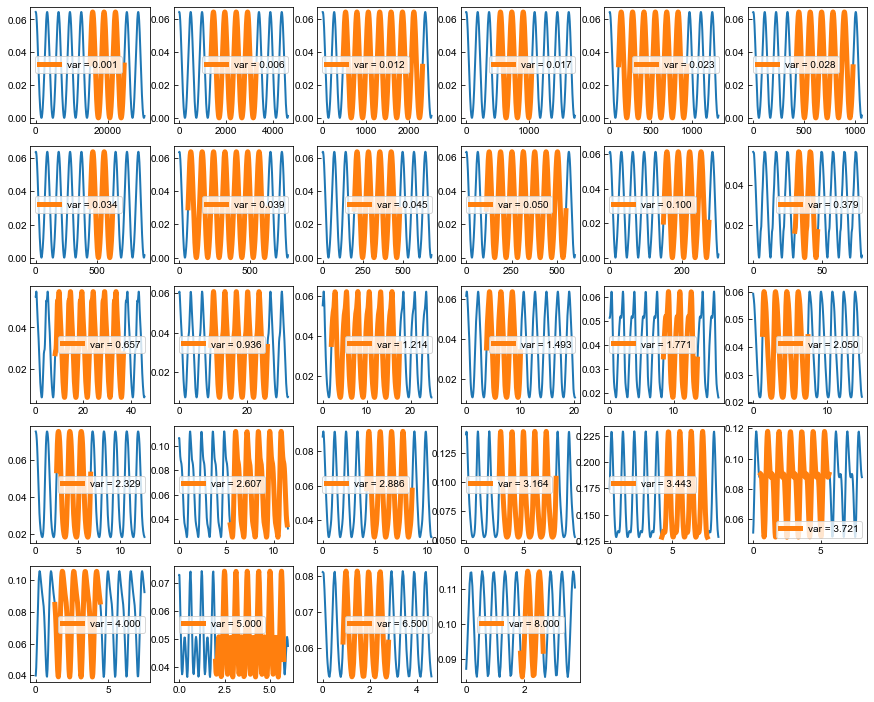

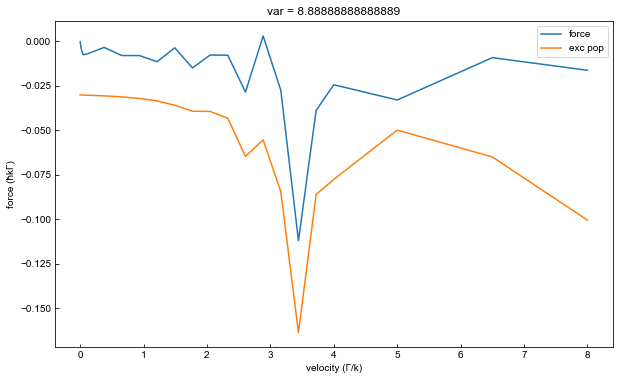

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:25<00:00,  1.08it/s]


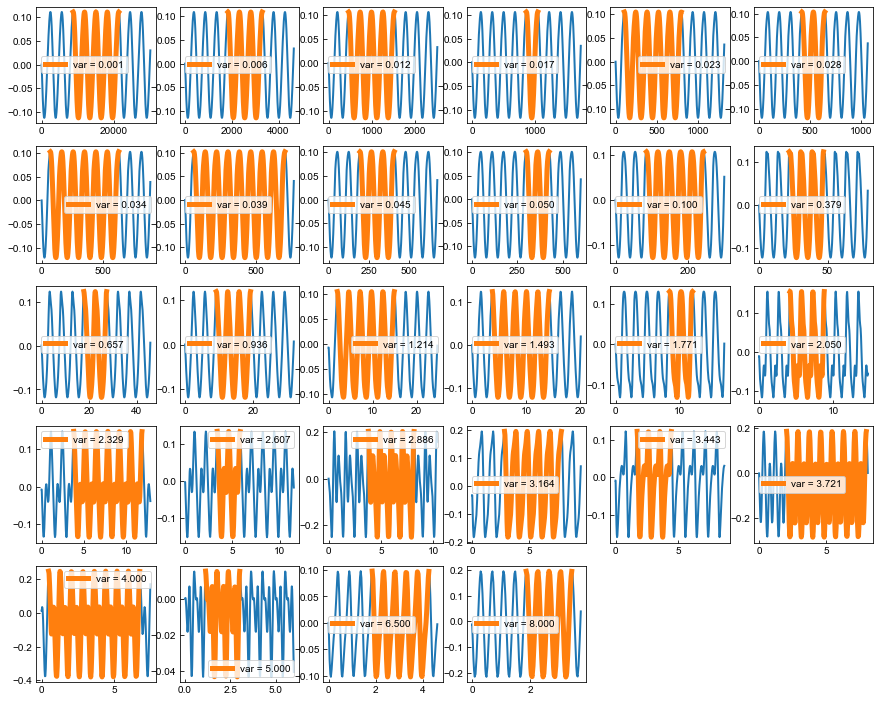

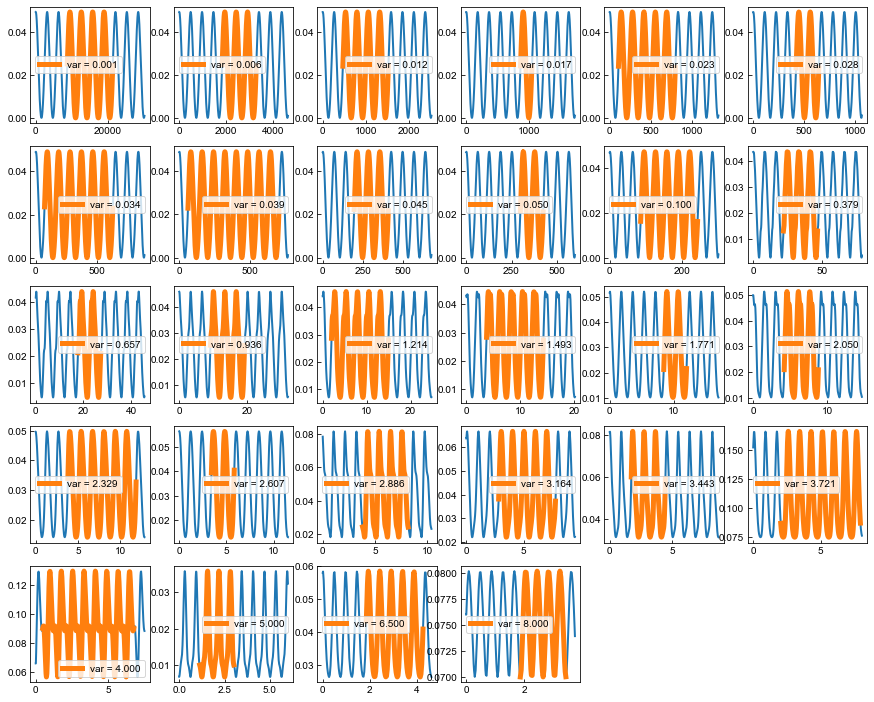

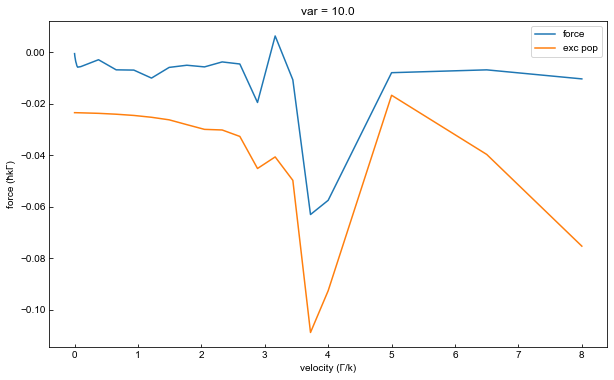

Wall time: 7min 28s


In [40]:
%%time
# var_input = np.linspace(0.001,1.5,20)
# var_input = np.concatenate([np.linspace(0.001,1.5,30),np.linspace(1.7,7,15),np.linspace(8,40,30)])
var_input = np.concatenate([np.linspace(0.001,0.05,10), np.linspace(0.1,4,15), np.linspace(5,8,3)])
# var_input = np.concatenate([np.linspace(0,10,8)])
# scndvar_list = 10**np.linspace(-3,1,10)
scndvar_list = np.linspace(0.0,10,10)
# scndvar_list = np.linspace(2,5,1)
force_storage = []
for scndvar_ind in range(len(scndvar_list)):
    force_output = sweep_vel_get_force(varlist=var_input, Δ_input=2.5,
                                       B_input=scndvar_list[scndvar_ind], θ_input=30/180*np.pi, Ω_val=10*np.sqrt(2))
    plt.title(f'var = {scndvar_list[scndvar_ind]}')
    plt.show()
    force_storage.append(force_output)
    
# force_storage = np.array(force_storage)
# t_curent = time.localtime()
# current_time = time.strftime("%Y_%m_%d_%H_%M_%S", t_curent)
# np.savez(current_time, var_input=var_input, scndvar_list=scndvar_list, force_storage=force_storage)

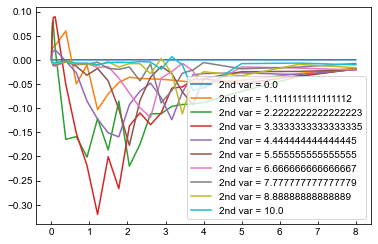

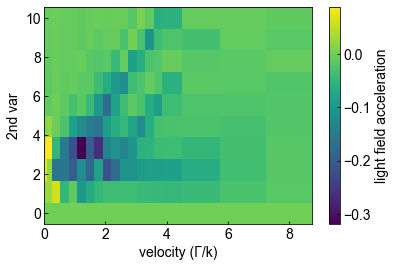

In [42]:
f, ax = plt.subplots(figsize = (6,4))
for scndvar_ind in range(len(scndvar_list)):
    ax.plot(var_input,force_storage[scndvar_ind],label=f'2nd var = {scndvar_list[scndvar_ind]}')
plt.legend()
plt.show()

X, Y = np.meshgrid(var_input, scndvar_list)
fig, ax = plt.subplots(figsize = (6,4))
c = ax.pcolormesh(X, Y, np.array(force_storage), shading="auto")
cbar = fig.colorbar(c)
ax.set_xlabel('velocity (Γ/k)')
ax.set_ylabel('2nd var')
# ax.set_yscale('log')
# ax.set_xlim([0, 1])
cbar.ax.set_ylabel('light field acceleration')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)